In [1]:
import osmnx as ox
import pandas as pd
import geopandas as gd
import networkx as nx
from scgraph.geographs.marnet import marnet_geograph
from shapely import geometry
import time 
ox.settings.bidirectional_network_types = ["drive"]

''' Определение тегов '''
tags_port = {'industrial' : 'port'}
tags_aeroway = {'aeroway' : ['aerodrome','heliport', 'airstrip']}
tags_landuse = {'landuse' : 'railway'}
tags_build = {'building' : 'warehouse', 'amenity' : 'mailroom'}

''' Построение датафрейма нужных фич '''
def func_tags(tags, city):

    try:
        gdf = ox.features_from_place(city, tags).reset_index()
        gdf = gdf[['element_type', 'osmid']]
        gdf['n_osmid'] = gdf['element_type'].apply(lambda x: x[0]) + gdf['osmid'].astype(str)

        list_lat_lon = []
        for i in range(gdf.n_osmid.shape[0]):
            try:
                bb = ox.geocode_to_gdf(gdf.n_osmid.iloc[i], by_osmid=True)[['lat', 'lon']]
                list_lat_lon.append(bb.iloc[:])
            except ox._errors.InsufficientResponseError:
                list_lat_lon.append(pd.DataFrame({'lat': [None], 'lon': [None]}))
        dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
        gdf = gdf.merge(dfs, on=dfs.index).drop('key_0', axis=1)
        gdf = gdf[['lat', 'lon']]
        gdf['kind_of'] = list(tags.keys())[0]
        gdf = gdf.dropna().reset_index(drop=True)
        return gdf
    except ox._errors.InsufficientResponseError:
        return None

''' Построение графа, получение датафрейма фич и получение датафрейма долгот и широт для дальшейших вычислений '''
def create_graph_city(name_city, my_network_type = None, my_filter = None):
    full_df = pd.concat([func_tags(tags_port, name_city), 
                                    func_tags(tags_aeroway, name_city), 
                                    func_tags(tags_landuse, name_city), 
                                    func_tags(tags_build, name_city)], ignore_index=True)
    G = ox.graph_from_place(name_city, retain_all=True, simplify = True, network_type = my_network_type, custom_filter = my_filter)

    lat = list(full_df['lat'].values)
    lon = list(full_df['lon'].values)

    return full_df, G, lat, lon

''' Формирование датафрейма фич '''
def create_features_city(features_df, city_graph, lat, lon):
    features_df['new_nodes'] = ox.distance.nearest_nodes(city_graph, lon, lat)
    return features_df


''' Создание датафрейма со всеми маршрутами '''
def create_graph_route(input_graph, f_df):
    one_route = []
    for i in range(f_df.shape[0]):
        for j in range(i + 1, f_df.shape[0]):
            try:
                one_route.append(nx.shortest_path(input_graph, f_df['new_nodes'].iloc[i], f_df['new_nodes'].iloc[j]))
            except nx.NetworkXNoPath:
                pass
    route_df = pd.DataFrame({'route' : one_route})
    return route_df


''' Создание из нескольких LineString один MultiLineString - нужно для финального графа '''
def create_gdf_graph(nn, ee):
    ii = 0
    list_line = []
    list_multi_line = []
    for i in range(nn.shape[0] - 1):
        idx = nn.iloc[i + 1].new_nodes
        for j in range(ii, ee.index.get_level_values('u').shape[0]):
            if ee.index.get_level_values('u')[j] != idx:
                for k in range(len(ee.loc[ee.index.get_level_values('u')[j]]['geometry'].values)):
                    list_line.append(ee.loc[ee.index.get_level_values('u')[j]]['geometry'].values[k])
            else : 
                ii = j
        multi_line = geometry.MultiLineString(list_line)
        list_line = []
        list_multi_line.append(multi_line)
    return list_multi_line


''' Построение финального графа путей '''
def create_final_graph(arb_graph, route_df, feature_df):
    list_graphs = []
    for i in range(route_df.route.shape[0]):
        r = route_df['route'].values[i]

        rr = pd.DataFrame({'new_nodes' : r})
        rr['osmid'] = rr['new_nodes']
        rr = rr.set_index('osmid')
        rr['x'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['x'])
        rr['y'] = rr.new_nodes.apply(lambda x: arb_graph.nodes[x]['y'])
        rr

        edge_dict = {'u': rr.new_nodes[:-1].values, 'v': rr.new_nodes[1:].values, 'key': 0}
        edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
        edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])

        graph_attrs = {"crs": "WGS84"}
        multi_digraph_aero = ox.convert.graph_from_gdfs(
            rr, edge_gdf, graph_attrs=graph_attrs)
        
        list_graphs.append(multi_digraph_aero)
        
    my_graph = list_graphs[0]
    for i in range(1, len(list_graphs)):
        my_graph = nx.compose_all([my_graph, list_graphs[i]])

    nodes, edges = ox.graph_to_gdfs(my_graph)
    list_nodes = list(feature_df['new_nodes'].values)
    n = nodes[nodes['new_nodes'].isin(list_nodes)]

    list_multiline = create_gdf_graph(n, edges)
    edge_dict = {'u': n.new_nodes[:-1].values, 'v': n.new_nodes[1:].values, 'key': 0}
    edge_gdf = gd.GeoDataFrame(edge_dict, crs=None)
    edge_gdf = edge_gdf.set_index(['u', 'v', 'key'])
    edge_gdf['geometry'] = list_multiline
    graph_attrs = {"crs": "WGS84"}
    multi_digraph = ox.graph_from_gdfs(
        n, edge_gdf, graph_attrs=graph_attrs)
    
    return multi_digraph

In [2]:
# 定义 result 函数
def result(name_city):
    start_time = time.time()  # 记录开始时间

    graph_city = create_graph_city(name_city, my_network_type='drive')
    feature_df = create_features_city(*graph_city)
    ox.distance.add_edge_lengths(graph_city[1], edges=None)
    route_df = create_graph_route(graph_city[1], feature_df)
    final_graph_1_drive = create_final_graph(graph_city[1], route_df, feature_df)

    end_time = time.time()  # 记录结束时间
    elapsed_time = end_time - start_time  # 计算总耗时

    print(f"Total execution time: {elapsed_time:.2f} seconds")  # 输出总耗时

    return final_graph_1_drive

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 22646.91 seconds


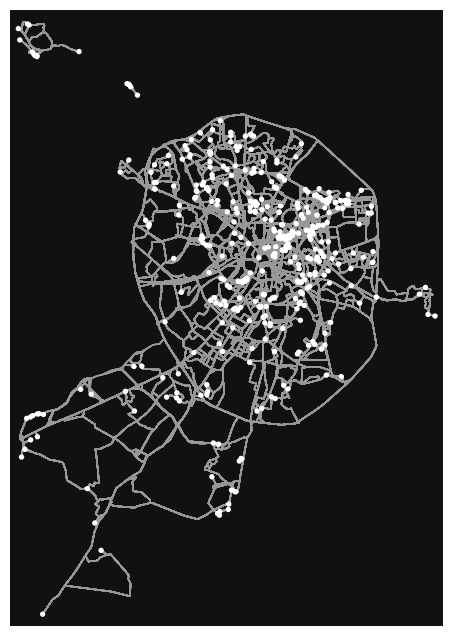

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
name_city = 'Moscow'#Москва
res_1 = result(name_city)
ox.plot_graph(res_1)

C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depr

Total execution time: 6300.98 seconds


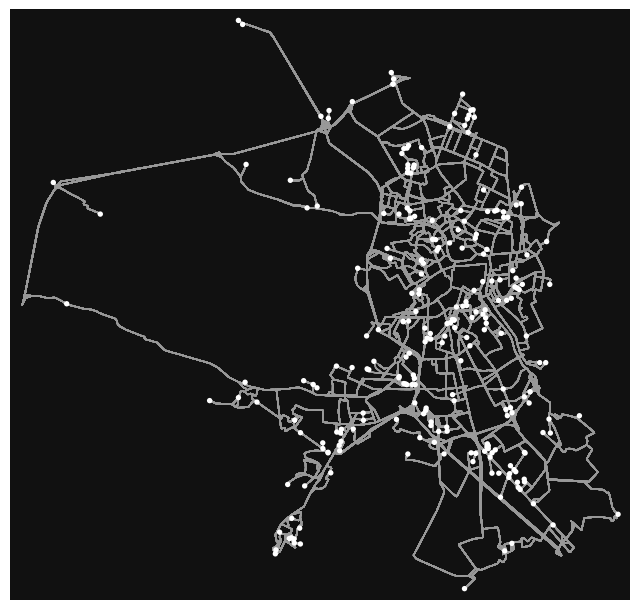

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [18]:
name_city = 'Saint Petersburg'#Санкт-Петербург
res_2 = result(name_city)
ox.plot_graph(res_2)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 246.42 seconds


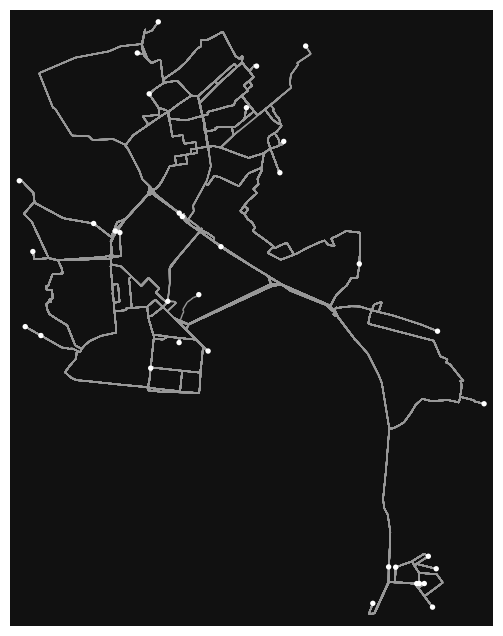

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
name_city = 'Novosibirsk'#Новосибирск
res_3 = result(name_city)
ox.plot_graph(res_3)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 355.33 seconds


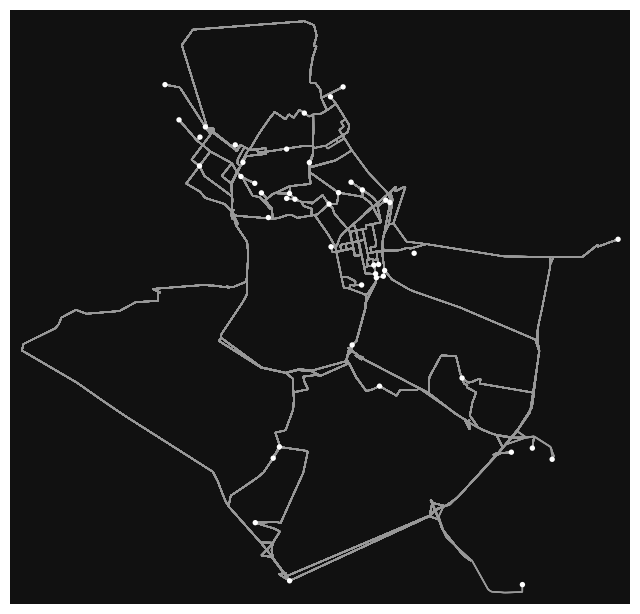

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
name_city = 'Yekaterinburg'#Екатеринбург
res_4 = result(name_city)
ox.plot_graph(res_4)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 45.83 seconds


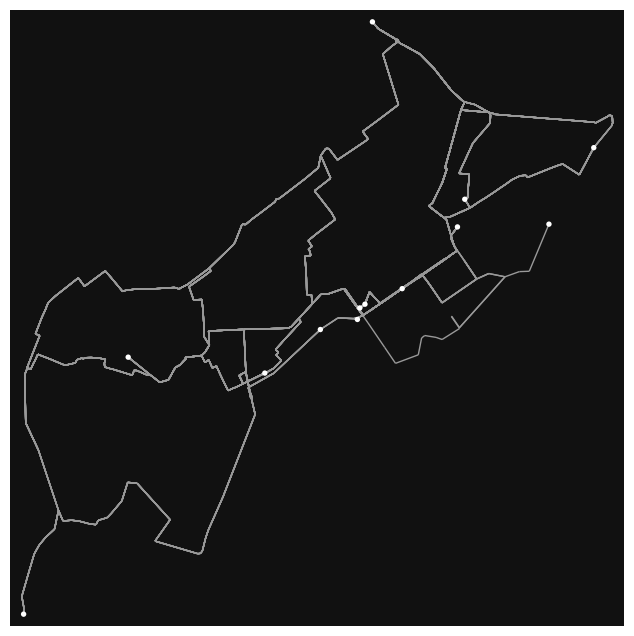

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [22]:
name_city = 'Samara'
res_5 = result(name_city)
ox.plot_graph(res_5)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 62.87 seconds


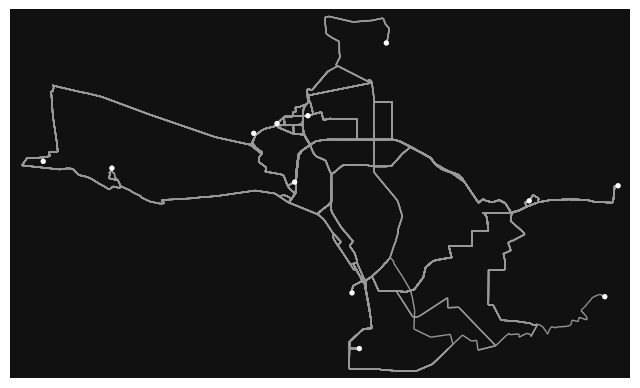

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
name_city = 'Kazan'#Казань
res_6 = result(name_city)
ox.plot_graph(res_6)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


Total execution time: 182.57 seconds


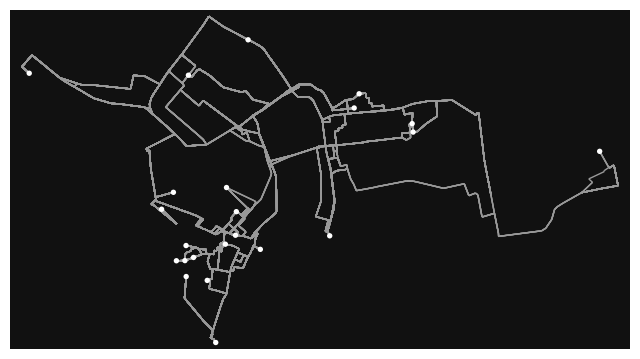

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
name_city = 'Omsk'#Омск
res_7 = result(name_city)
ox.plot_graph(res_7)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 178.92 seconds


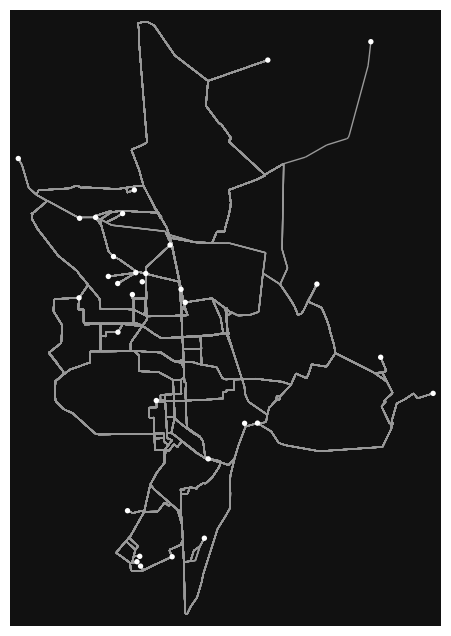

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [27]:
name_city = 'Chelyabinsk'
res_8 = result(name_city)
ox.plot_graph(res_8)

C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 74.39 seconds


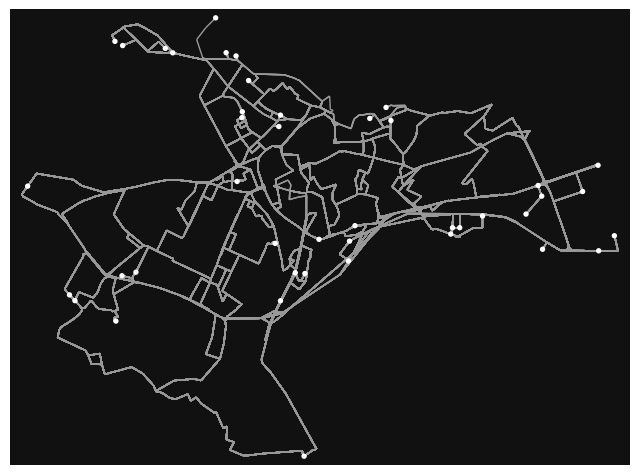

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
name_city = 'Tallin'
res_9 = result(name_city)
ox.plot_graph(res_9)

C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depr

Total execution time: 483.64 seconds


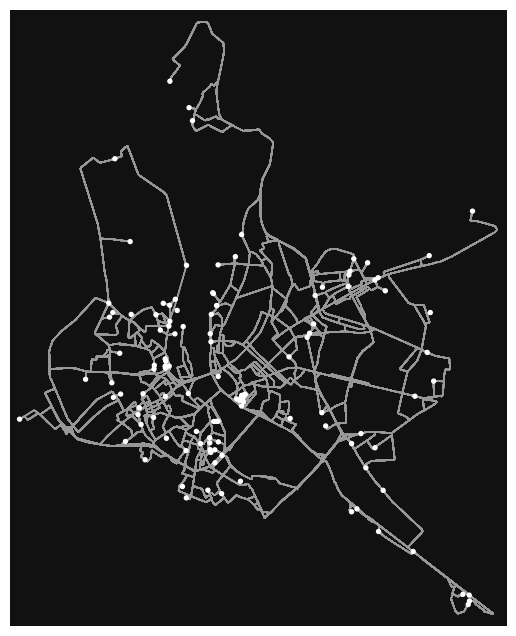

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [15]:
name_city = 'Riga'
res_10 = result(name_city)
ox.plot_graph(res_10)

C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),
C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an 

Total execution time: 19.40 seconds


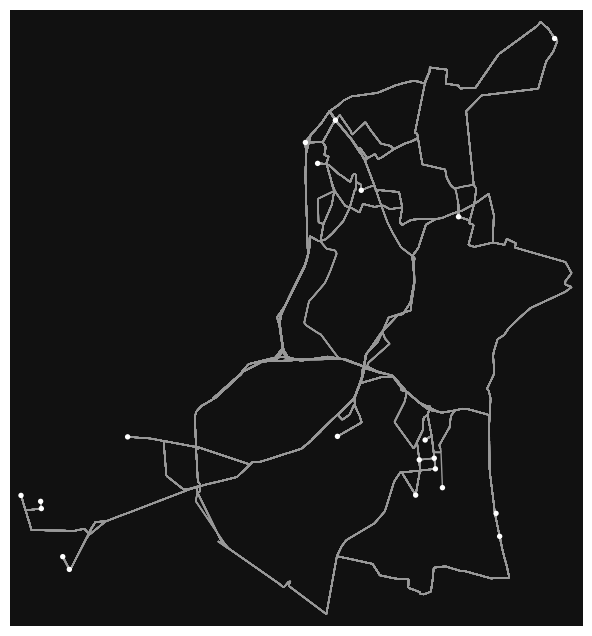

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [16]:
name_city = 'Vilnius'#Вильнюс
res_11 = result(name_city)
ox.plot_graph(res_11)

C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 0.90 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_20508\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


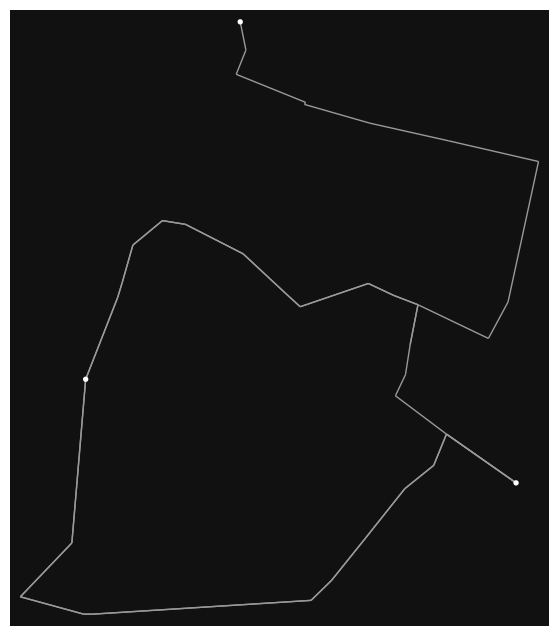

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [17]:
name_city = 'Strelna'
res_12 = result(name_city)
ox.plot_graph(res_12)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an 

Total execution time: 78.04 seconds


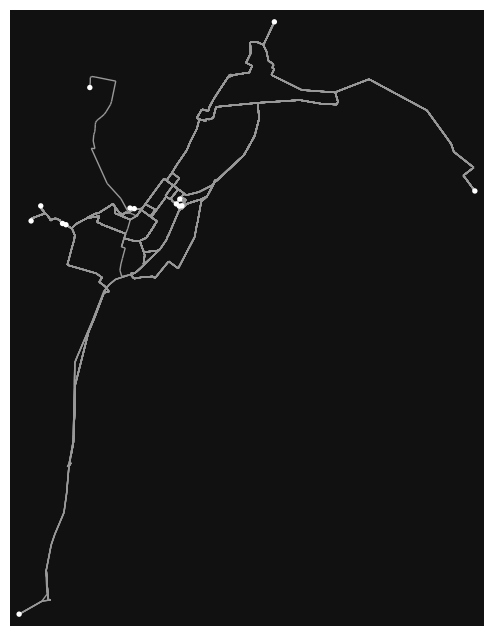

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [10]:
name_city = 'Ufa'
res_13 = result(name_city)
ox.plot_graph(res_13)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an 

Total execution time: 330.71 seconds


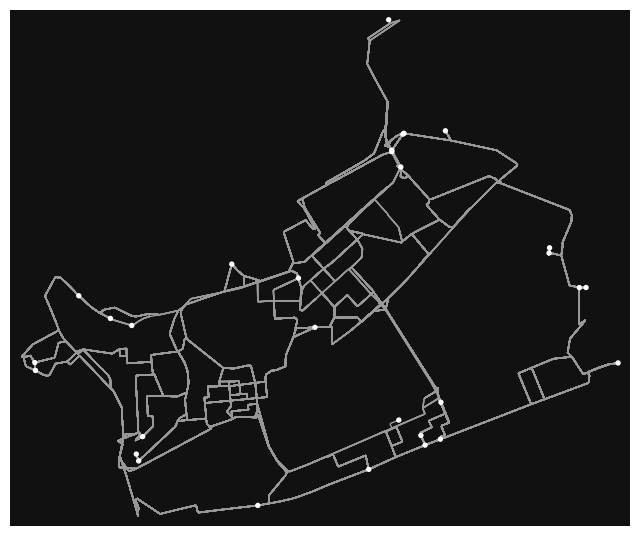

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [11]:
name_city = 'Krasnoyarsk'
res_14 = result(name_city)
ox.plot_graph(res_14)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 109.46 seconds


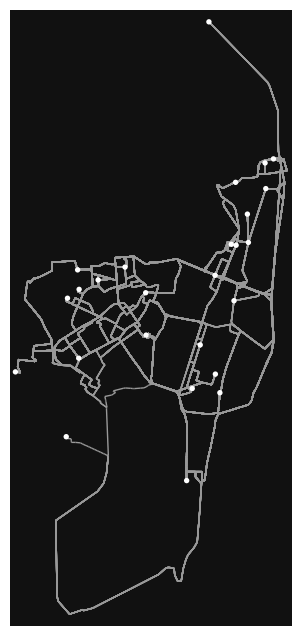

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [12]:
name_city = 'Voronezh'
res_15 = result(name_city)
ox.plot_graph(res_15)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 85.22 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


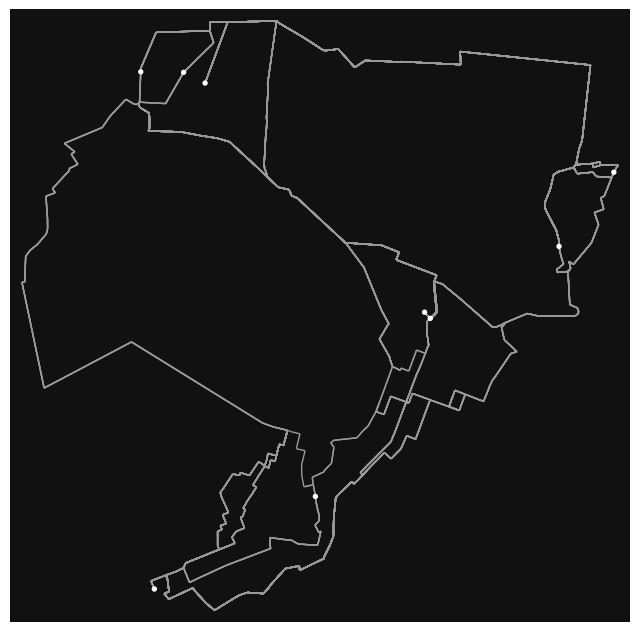

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [13]:
name_city = 'Saratov'
res_16 = result(name_city)
ox.plot_graph(res_16)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 64.65 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


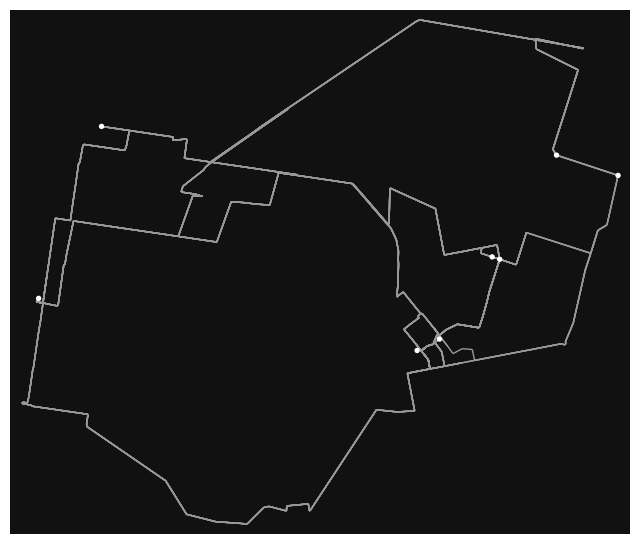

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
name_city = 'Togliatti'
res_17 = result(name_city)
ox.plot_graph(res_17)

D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 78 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 78 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 78 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo

Total execution time: 324.45 seconds


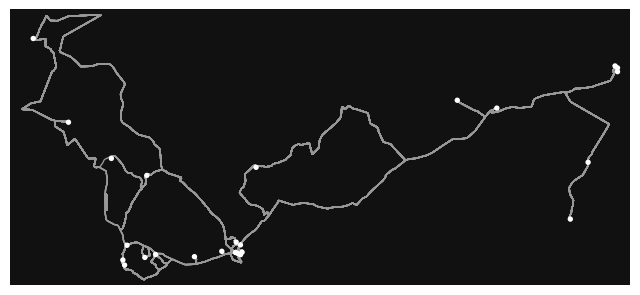

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [26]:
name_city = 'Vologda'
res_18 = result(name_city)
ox.plot_graph(res_18)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


Total execution time: 105.67 seconds


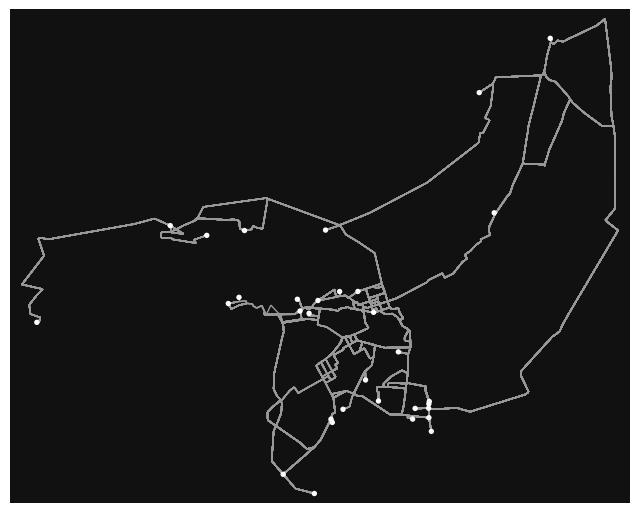

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [25]:
name_city = 'Perm'
res_19 = result(name_city)
ox.plot_graph(res_19)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 112.85 seconds


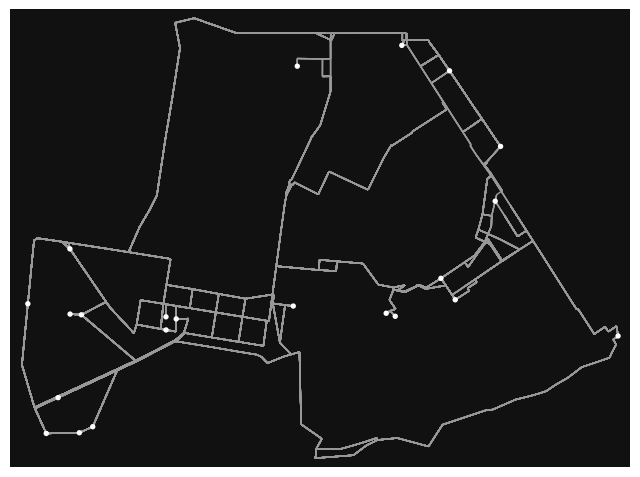

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [24]:
name_city = 'Barnaul'
res_20 = result(name_city)
ox.plot_graph(res_20)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 104.66 seconds


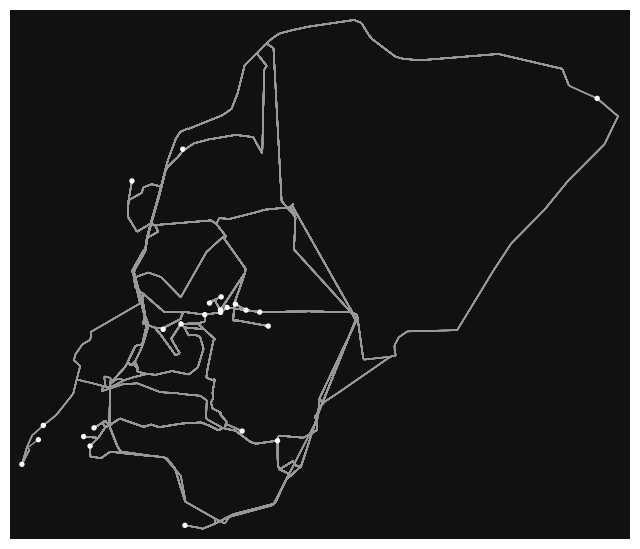

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [23]:
name_city = 'Vladivostok '
res_21 = result(name_city)
ox.plot_graph(res_21)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 63.76 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


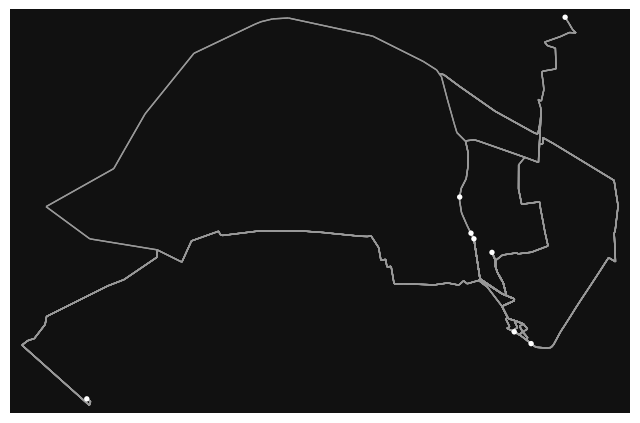

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [28]:
name_city = 'Chita '
res_22 = result(name_city)
ox.plot_graph(res_22)

D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 145 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 145 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 145 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_

Total execution time: 1086.12 seconds


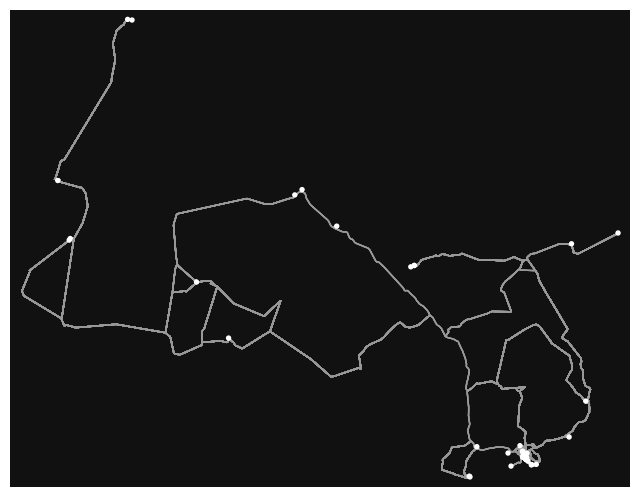

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [32]:
name_city = 'Tomsk '
res_23 = result(name_city)
ox.plot_graph(res_23)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),


Total execution time: 29.97 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


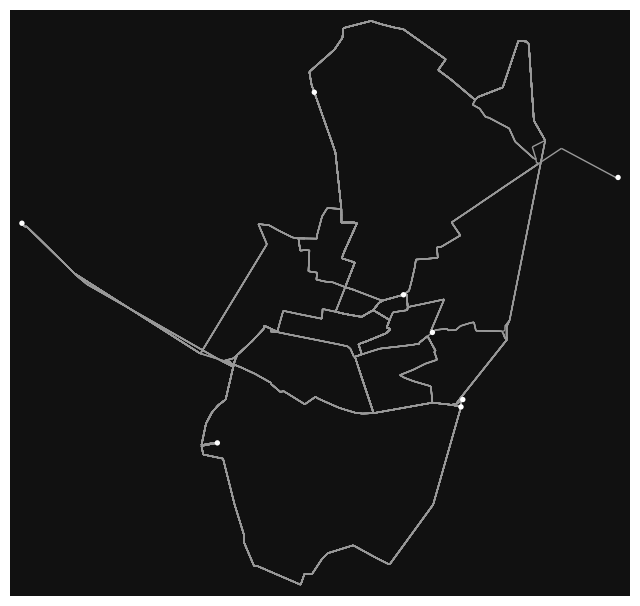

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [33]:
name_city = 'Kaluga'
res_24 = result(name_city)
ox.plot_graph(res_24)

C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_11960\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed with

Total execution time: 8.12 seconds


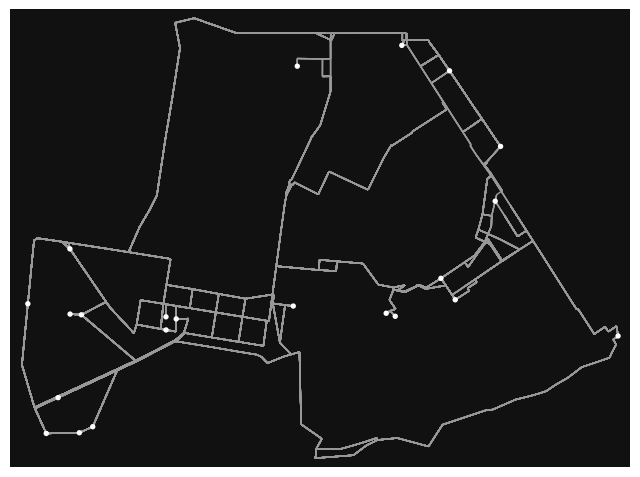

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [34]:
name_city = 'Barnaul'
res_25 = result(name_city)
ox.plot_graph(res_25)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without

Total execution time: 31.81 seconds


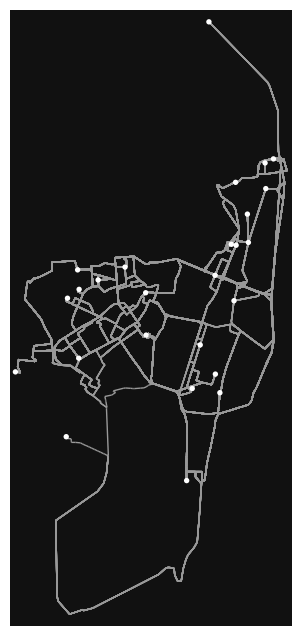

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
name_city = 'Voronezh'
res_26 = result(name_city)
ox.plot_graph(res_26)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 5.33 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


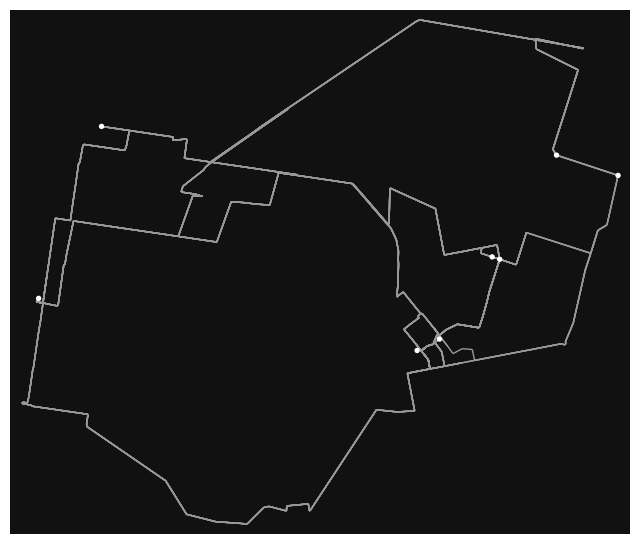

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
name_city = 'Tolyatti'
res_27 = result(name_city)
ox.plot_graph(res_27)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),


Total execution time: 84.01 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


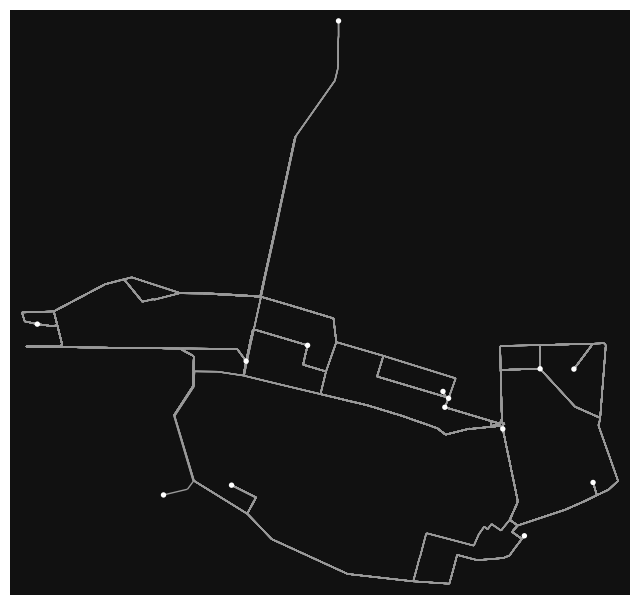

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
name_city = 'Surgut'
res_28 = result(name_city)
ox.plot_graph(res_28)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),


Total execution time: 18.44 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


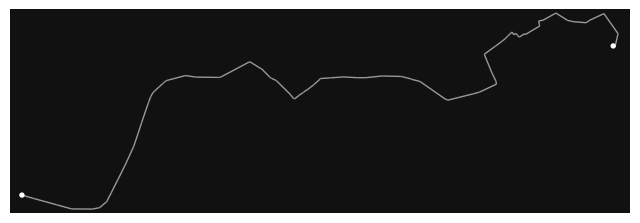

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
name_city = 'Ulan-Ude'
res_29 = result(name_city)
ox.plot_graph(res_29)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an act

Total execution time: 145.34 seconds


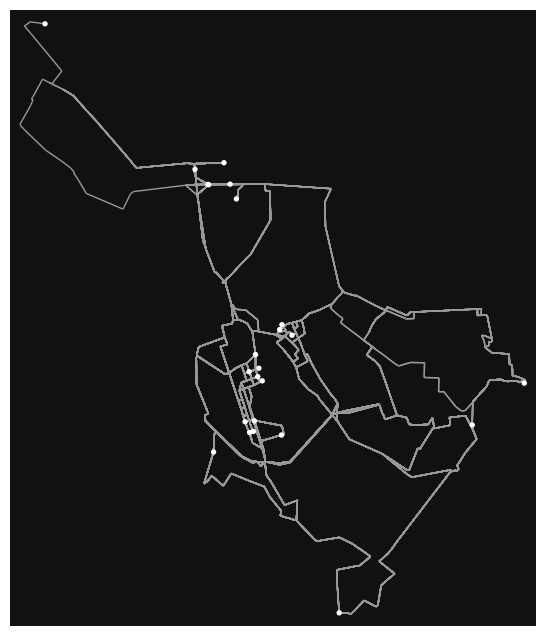

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
name_city = 'Irkutsk'
res_30 = result(name_city)
ox.plot_graph(res_30)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depreca

Total execution time: 164.33 seconds


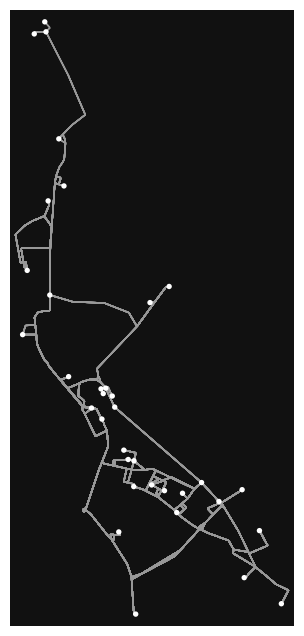

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
name_city = 'Arkhangelsk'
res_31 = result(name_city)
ox.plot_graph(res_31)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),


Total execution time: 18.38 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


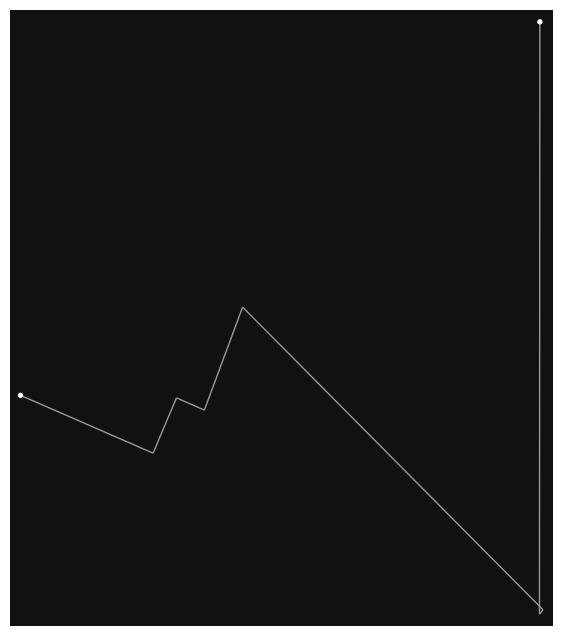

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
name_city = 'Makhachkala'
res_32 = result(name_city)
ox.plot_graph(res_32)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),


Total execution time: 50.48 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


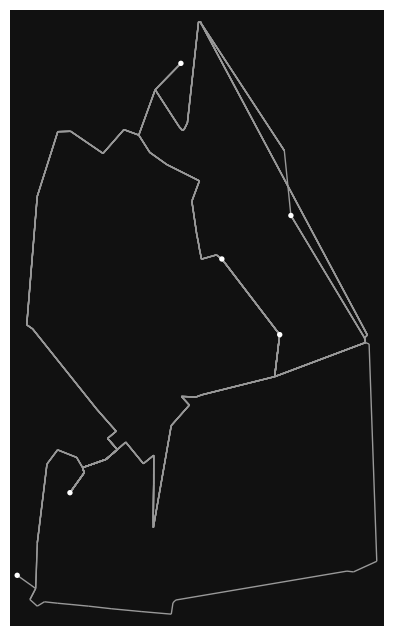

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [10]:
name_city = 'Murmansk'
res_33 = result(name_city)
ox.plot_graph(res_33)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),


Total execution time: 66.57 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


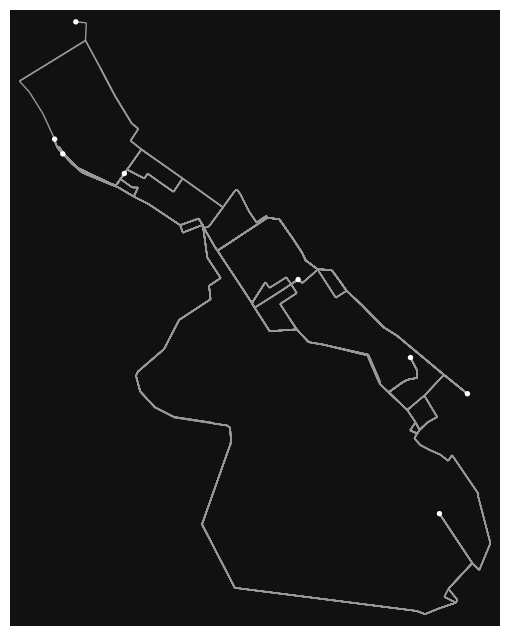

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [11]:
name_city = 'Petrozavodsk'
res_34 = result(name_city)
ox.plot_graph(res_34)

D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 78 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 78 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
D:\MyApplication\annaconda\anacondaaa\envs\system\Lib\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 78 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo

Total execution time: 94.42 seconds


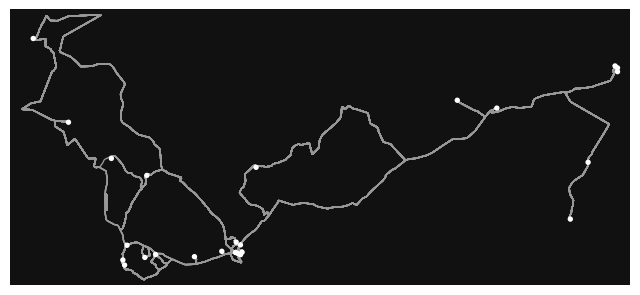

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [12]:
name_city = 'Vologda'
res_35 = result(name_city)
ox.plot_graph(res_35)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without

Total execution time: 235.61 seconds


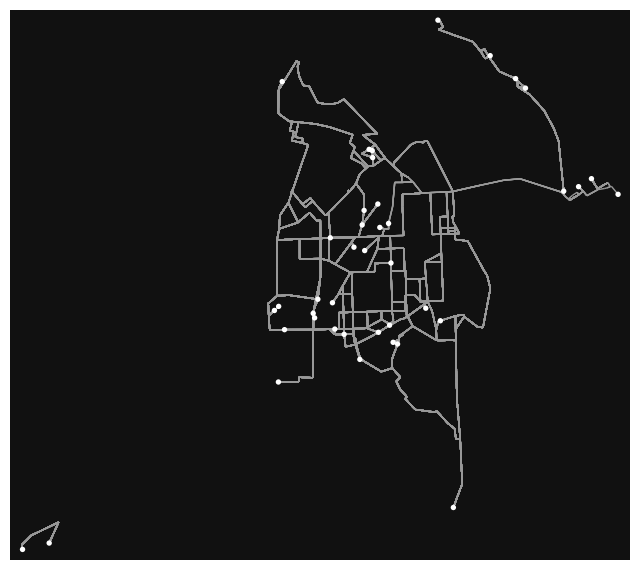

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [13]:
name_city = 'Kirov'
res_36 = result(name_city)
ox.plot_graph(res_36)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),


Total execution time: 18.30 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


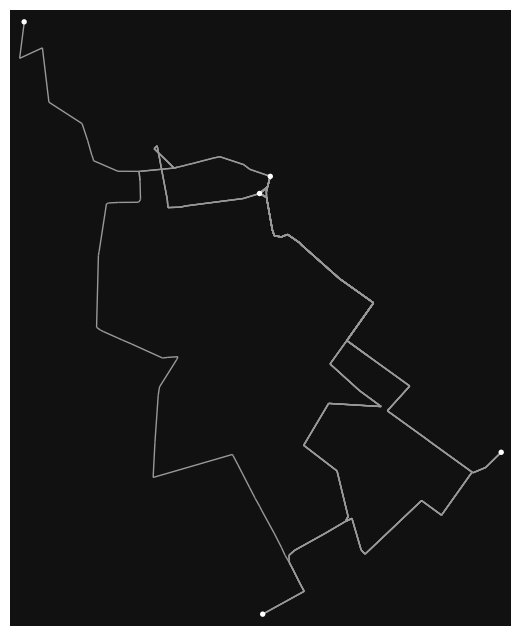

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
name_city = 'Smolensk'
res_37 = result(name_city)
ox.plot_graph(res_37)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 59.69 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


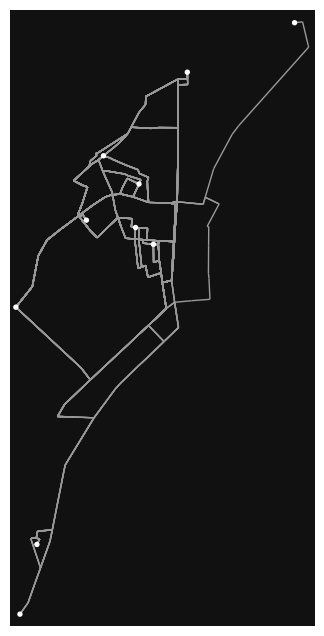

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [18]:
name_city = 'Yakutsk'
res_38 = result(name_city)
ox.plot_graph(res_38)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),


Total execution time: 84.78 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


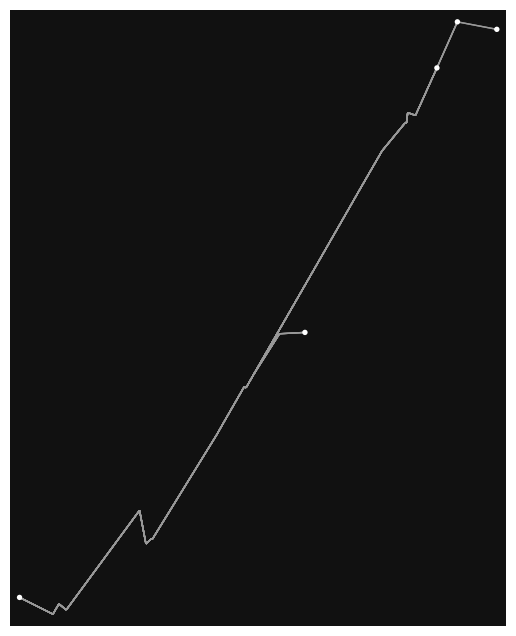

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [16]:
name_city = 'Cheboksary'
res_39 = result(name_city)
ox.plot_graph(res_39)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),


Total execution time: 21.03 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


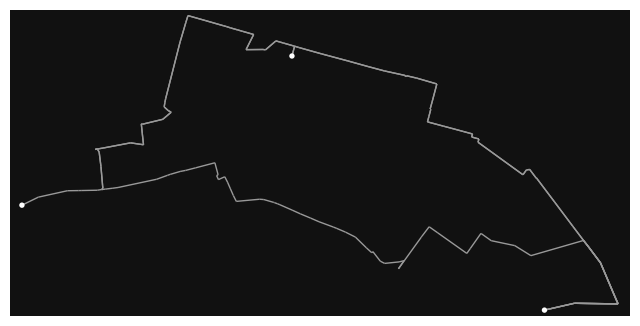

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [17]:
name_city = 'Tver'
res_40 = result(name_city)
ox.plot_graph(res_40)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 20.66 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


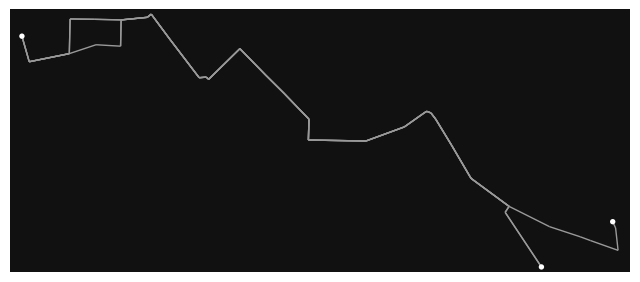

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [19]:
name_city = 'Novokuznetsk'
res_41 = result(name_city)
ox.plot_graph(res_41)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 12.85 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


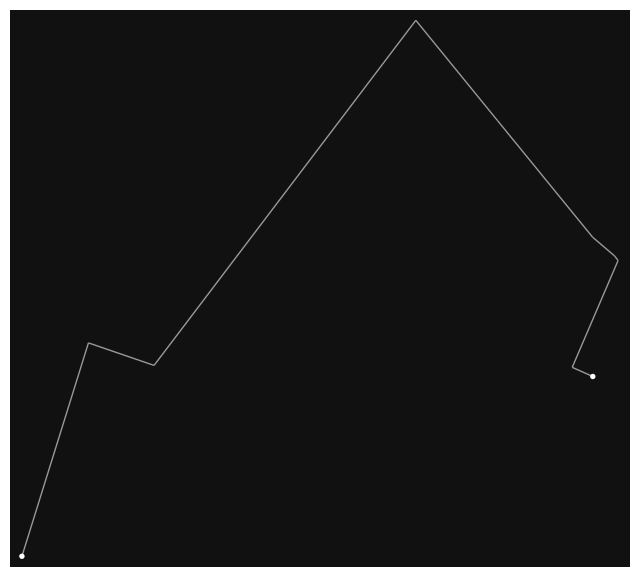

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [20]:
name_city = 'Veliky Novgorod'
res_42 = result(name_city)
ox.plot_graph(res_42)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),


Total execution time: 7.29 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


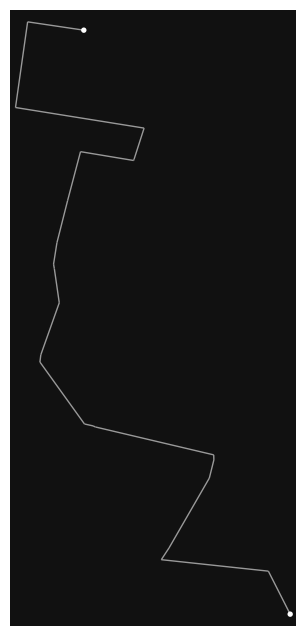

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [32]:
name_city = 'Cherepovets'
res_43 = result(name_city)
ox.plot_graph(res_43)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 243.93 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


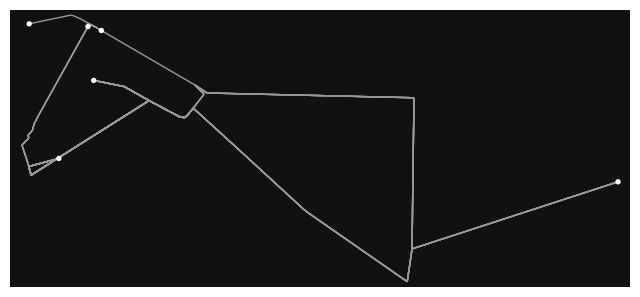

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [22]:
name_city = 'Nizhnekamsk'
res_44 = result(name_city)
ox.plot_graph(res_44)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 21.43 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


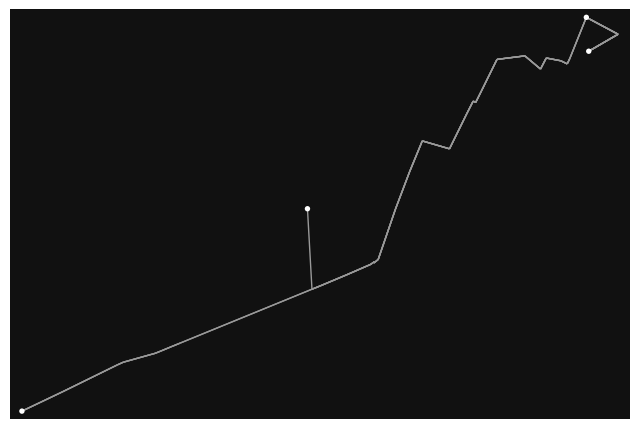

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [31]:
name_city = 'Vladimir'
res_45 = result(name_city)
ox.plot_graph(res_45)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),


Total execution time: 41.35 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


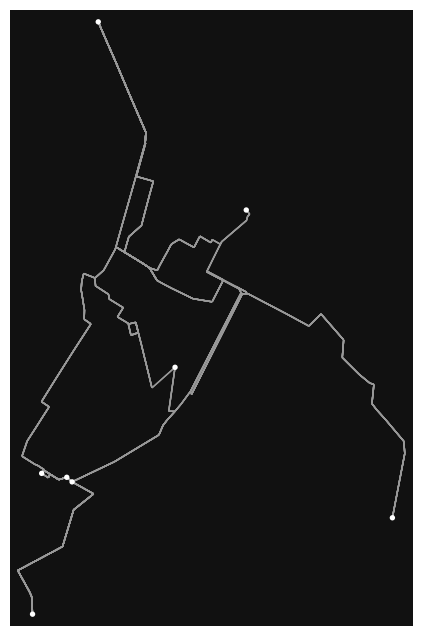

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [30]:
name_city = 'Tula'
res_46 = result(name_city)
ox.plot_graph(res_46)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 31.19 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


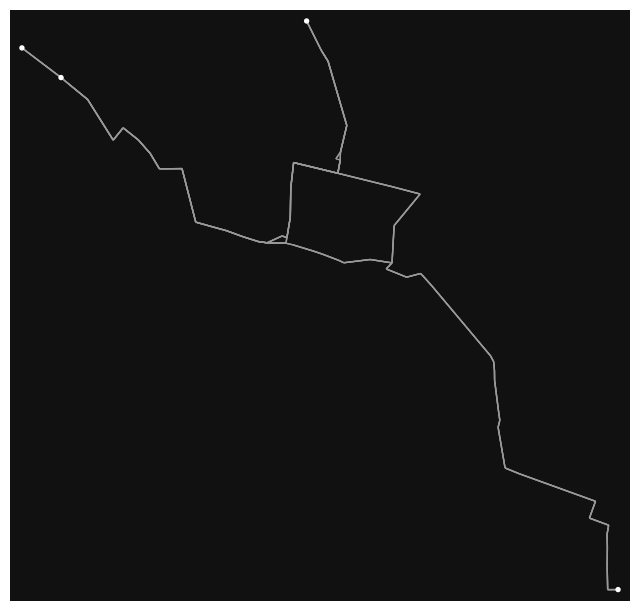

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [25]:
name_city = 'Kamensk-Uralsky'
res_47 = result(name_city)
ox.plot_graph(res_47)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 85.99 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


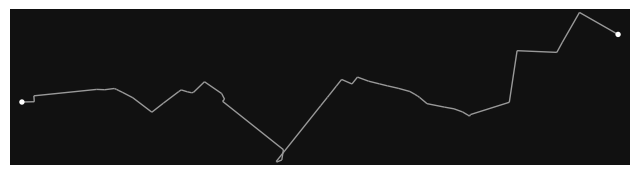

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [29]:
name_city = 'Kostroma'
res_48 = result(name_city)
ox.plot_graph(res_48)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)
C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat([func_tags(tags_port, name_city),


Total execution time: 35.35 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


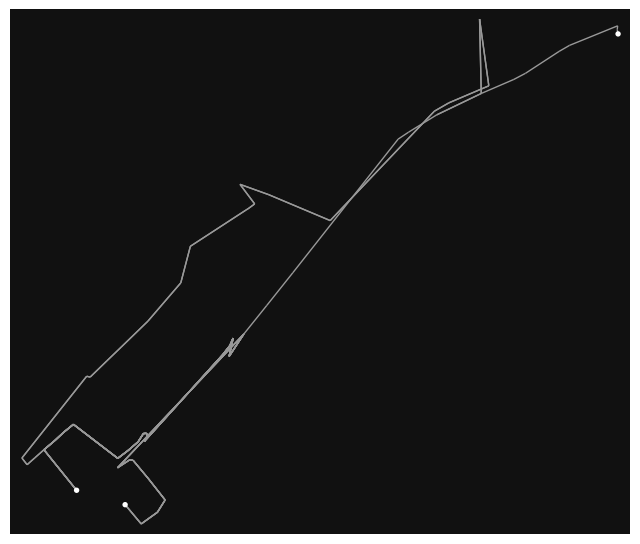

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [27]:
name_city = 'Mytishchi'
res_49 = result(name_city)
ox.plot_graph(res_49)

C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(list_lat_lon, axis=0).reset_index(drop=True)


Total execution time: 8.32 seconds


C:\Users\cc\AppData\Local\Temp\ipykernel_7984\3023041969.py:126: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  edge_gdf['geometry'] = list_multiline


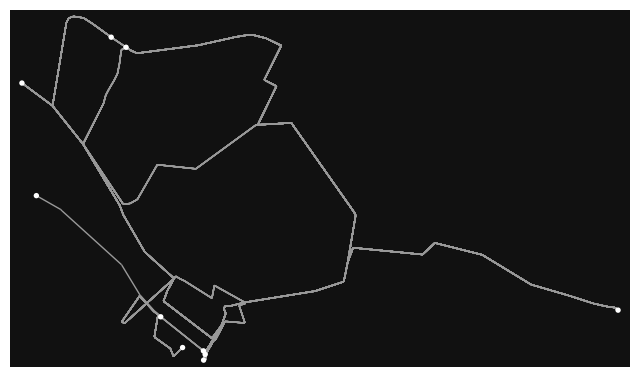

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [28]:
name_city = 'Zelenograd'
res_50 = result(name_city)
ox.plot_graph(res_50)

In [ ]:
#nodes_1, edges_1 = ox.graph_to_gdfs(res_1)
#nodes_2, edges_2 = ox.graph_to_gdfs(res_2)
#nodes_3, edges_3 = ox.graph_to_gdfs(res_3)
#nodes_4, edges_4 = ox.graph_to_gdfs(res_4)

#nodes_1.to_csv('data/nodes_tallin.csv')
#edges_1.to_csv('data/edges_tallin.csv')
#nodes_2.to_csv('data/nodes_riga.csv')
#edges_2.to_csv('data/edges_riga.csv')
#nodes_3.to_csv('data/nodes_vilnius.csv')
#edges_3.to_csv('data/edges_vilnius.csv')
#nodes_4.to_csv('data/nodes_strelna.csv')
#edges_4.to_csv('data/edges_strelna.csv')